In [1]:
from IPython.display import display, Math, Markdown
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy import ndimage
import scipy.optimize as opt
import sys

In [2]:
# (x,y) are 2D numpy arrays, specifying the Cartesian domain of the function
# (xc, yc) is the center of the laser pulse
# (phi_min, phi_max) are the min/max values of the wavefront phase
# r_max is approximately the maximum radius of the image
# r_mid ~ 0.2*r_max is user-specified, with a value that might need tweaking
# r0 is the radial curvature of phi(r), for r < r_mid
def spline_wfs(x, y, xc, yc, r_mid, r_max, phi_min, phi_max, r0):
    rsq = (x-xc)**2 + (y-yc)**2
    r = np.sqrt(rsq)
    phi_mid = phi_max * (1. - (r_mid/r0)**2)
    c0 = (phi_mid - phi_min) / (1. - r_mid/r_max)
    
    f_1 = phi_max * (1. - rsq/r0**2)
    f_2 = phi_min + c0 * (1. - r/r_max)
    return np.where(r<=r_mid, f_1, f_2)

# r0 and phi_max are the fitting parameters
def spline_wfs_fit(params, x, y, data, xc, yc, r_mid, r_max, phi_min):
    r0 = params[0]
    phi_max = params[1]
    g = spline_wfs(x, y, xc, yc, r_mid, r_max, phi_min, phi_max, r0)
    r = np.sqrt((x-xc)**2 + (y-yc)**2)
    weighted_diff = np.where(r<=r_mid, (g - data.reshape(g.shape))/r, 0.)
    return np.linalg.norm(weighted_diff)

In [3]:
# (x,y) are 2D numpy arrays, specifying the Cartesian domain of the function
# (xc, yc) is the center of the laser pulse
# n0_max is the maximum # of photon counts on a pixel, near the pulse center
# r_rms, the RMS radius of the 2D cylindrically symmetric gaussian
def gaussian_ccd(x, y, xc, yc, n0_max, r_rms):
    return n0_max * np.exp(-(((x-xc)/r_rms)**2 + ((y-yc)/r_rms)**2))

# r_rms and n0_max are the fitting parameters
def gaussian_ccd_fit(params, x, y, xc, yc, data, r_mid):
    r_rms = params[0]
    n0_max = params[1]
    g = gaussian_ccd(x, y, xc, yc, n0_max, r_rms)
    rsq = (x-xc)**2 + (y-yc)**2
    r = np.sqrt(rsq)
    weighted_diff = np.where(r<r_mid, (g - data.reshape(g.shape))/r, 0.)
    return np.linalg.norm(weighted_diff)

In [4]:
# compute an azimuthally averaged radial profile
# Code adapted from https://github.com/vicbonj/radialprofile/blob/master/radialProfile.py

def azimuthalAverage(image, centerx, centery, type='mean'):
    '''
    Compute spherically symetric profiles around a center
    Returns
    -------
    profiles, errors, distance to the center in pixels
    '''

    y, x = np.indices(image.shape)
    r = np.hypot(x - centerx, y - centery)

    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    r_int = r_sorted.astype(int)

    deltar = r_int[1:] - r_int[:-1]
    rind = np.where(deltar)[0]
    rind2 = rind+1
    rind3 = np.zeros(len(rind2)+1)
    rind3[1:] = rind2
    rind3 = rind3.astype('int')

    if type == 'mean':
        aaa = [np.nanmean(i_sorted[rind3[i]:rind3[i+1]]) for i in range(len(rind3)-1)]
    elif type == 'median':
        aaa = [np.nanmedian(i_sorted[rind3[i]:rind3[i+1]]) for i in range(len(rind3)-1)]
    elif type == 'mode':
        aaa_list = [i_sorted[rind3[i]:rind3[i+1]] for i in range(len(rind3)-1)]
        aaa = []
        for part in aaa_list:
            if len(part) == 1:
                counts, xed = np.histogram(part, bins=len(part))
            elif (len(part) > 1) & (len(part) < 40):
                counts, xed = np.histogram(part, bins=int(len(part)/2))
            else:
                counts, xed = np.histogram(part, bins=20)
            if len(xed) != 2:
                aaa.append(0.5*(xed[1:]+xed[:-1])[np.where(counts == np.max(counts))[0]][0])
            elif len(xed) == 2:
                aaa.append(0.5*(xed[1:]+xed[:-1])[np.where(counts == np.max(counts))[0]][0])
    else:
        raise ValueError('Nope')
    aaa_std = [np.nanstd(i_sorted[rind3[i]:rind3[i+1]]) for i in range(len(rind3)-1)]
    dist_r = [np.mean(r_sorted[rind3[i]:rind3[i+1]]) for i in range(len(rind3)-1)]
    return np.array(aaa), np.array(aaa_std), np.array(dist_r)

In [5]:
# specify the path to the diagnostic data files
# dir_name = 'rslaser/package_data/'
dir_name = '../../../rslaser/package_data/'
ccd_name = 'ccd_pump_off.txt'
wfs_name = 'wfs_pump_off.txt'

# read the pixel size from the diagnostic metadata file
# with open("rslaser/package_data/camera_sensor_info.txt") as fh:
with open("../../../rslaser/package_data/camera_sensor_info.txt") as fh:
    for line in fh:
        if line.startswith("\"pixel_size_h_microns\""):
            pixel_size = float(line.split(":")[-1].split(",")[0])  # microns
display(Markdown(' pixel size is {} [$\mu m$] by {} [$\mu m$]'.format(pixel_size,pixel_size)))

 pixel size is 6.9 [$\mu m$] by 6.9 [$\mu m$]

In [6]:
# parse the wave front sensor (WFS) diagnostic data file
wfs_data = np.genfromtxt(dir_name+wfs_name, skip_header=1, skip_footer=0)

# convert from microns to radians
lambda0_micron = 0.8
rad_per_micron = math.pi / lambda0_micron
wfs_data *= rad_per_micron
# print(' ')
# print('rad_per_micron = ', rad_per_micron)

# clean up any NaN's
wfs_data[np.isnan(wfs_data)] = 777
wfs_data[np.where(wfs_data==777)] = np.min(wfs_data)
# print(' ')
# print('np.shape(wfs_data) = ', np.shape(wfs_data))
# print('wfs_data = ')
# print(wfs_data)

x = np.linspace(0, wfs_data.shape[1] - 1, wfs_data.shape[1])
y = np.linspace(0, wfs_data.shape[0] - 1, wfs_data.shape[0])
x, y = np.meshgrid(x, y)
# print(' ')
# print('np.shape(x) = ', np.shape(x))
# print('x = ', x)
# print('y = ', y)

phi_min=np.min(wfs_data)
phi_max=np.max(wfs_data)
# print(' ')
print('phi_min = ', phi_min)
print('phi_max = ', phi_max)

phi_min =  -0.08604974843169766
phi_max =  0.08604974843169766


In [7]:
# parse the intensity (CCD) diagnostic data file
ccd_data = np.genfromtxt(dir_name+ccd_name, skip_header=1)
# print(' ')
# print('np.shape(ccd_data) = ', np.shape(ccd_data))
# print('ccd_data = ')
# print(ccd_data)

# we assume the WFS and CCD data are from the same diagnostic
# check that the data files have the same number of pixels
assert np.shape(wfs_data) == np.shape(ccd_data), error_message('ERROR -- WFS and CCD data have diferent shapes!!')

n0_min=np.min(ccd_data)
n0_max=np.max(ccd_data)
n0_tot = np.sum(ccd_data)
# print(' ')
print('n0_min = ', n0_min)
print('n0_max = ', n0_max)
print('n0_tot = ', n0_tot)

n0_min =  0.0
n0_max =  52817.0
n0_tot =  27219346.0


In [8]:
# find the center of the laser pulse
# in many cases, the WFS data is cleaner, with a well-defined center
# in comparison, the intensity data can be blotchy and asymmetric near the center
# when close to a waist, the WFS data does *NOT* have a well-defined center

# check whether the WFS data has a narrow range of phases
# if so, the laser pulse is close to a waist
CLOSE_TO_WAIST = False
if (phi_max-phi_min) < 0.1*math.pi:
    print('Laser pulse is close to a waist!')
    CLOSE_TO_WAIST = True

yc_ccd, xc_ccd = ndimage.measurements.center_of_mass(ccd_data)
if CLOSE_TO_WAIST:
    # take the center from the CCD data
    yc_wfs, xc_wfs = 'UNDEFINED', 'UNDEFINED'
    (xc0, yc0) = (xc_ccd, yc_ccd)
    print('xc_ccd ~ {0:4.1f}'.format(xc_ccd)+'; yc_ccd ~ {0:4.1f} [pixels]'.format(yc_ccd))
else:
    # take the center from the WFS data
    yc_wfs, xc_wfs = ndimage.measurements.center_of_mass(wfs_data)
    (xc0, yc0) = (xc_wfs, yc_wfs)
    print('xc_wfs ~ {0:4.1f}'.format(xc_wfs)+'; yc_wfs ~ {0:4.1f} [pixels]'.format(yc_wfs))
    # display(Markdown('$x_{{c,wfs}}$ ~ {0:3.0f}'.format(xc_wfs*pixel_size)+'; $y_{{c,wfs}}$ ~ {0:3.0f} [$\mu m$]'.format(yc_wfs*pixel_size)))

# Approximate value for the maximum radius of the diagnostic images
r_max = max(np.linalg.norm(x[-1,0] - xc0),np.linalg.norm(x[0,-1] - yc0))
print('r_max = ', r_max)

Laser pulse is close to a waist!
xc_ccd ~ 20.0; yc_ccd ~ 14.4 [pixels]
r_max =  24.575095081270504


In [9]:
# use nonlinear optimization to find the radius of curvature for ph(r), near r=0
if CLOSE_TO_WAIST:
    r_mid = 2.*r_max
    phi_avg = 0.5*(phi_min + phi_max)
    phi_min = phi_avg
    phi_max = phi_avg
else:
    r_mid = 0.18*r_max

print('r_mid = ', r_mid)
r0 = 0.2*r_max
x0=(r0, phi_max)

args=(x, y, wfs_data.flatten(), xc0, yc0, r_mid, r_max, phi_min)

result = opt.minimize(spline_wfs_fit, x0, args, method='Nelder-Mead', options={'maxiter': 1e4, 'xatol': 0.0000001, 'fatol': 0.0000001})
print(' ')
print('result = ', result)

r_mid =  49.15019016254101
 
result =   final_simplex: (array([[1.91603173e+01, 1.30031782e-02],
       [1.91603174e+01, 1.30031782e-02],
       [1.91603173e+01, 1.30031782e-02]]), array([0.06471954, 0.06471954, 0.06471954]))
           fun: 0.06471954103961344
       message: 'Optimization terminated successfully.'
          nfev: 167
           nit: 82
        status: 0
       success: True
             x: array([1.91603173e+01, 1.30031782e-02])


In [10]:
xc = xc0
yc = yc0
(r0, phi_max) = result.x
print('xc = ', xc)
print('yc = ', yc)
print('r0 = ', r0)
print('phi_min = ', phi_min)
print('phi_max = ', phi_max)

wfs_fit = spline_wfs(x, y, xc, yc, r_mid, r_max, phi_min, phi_max, r0)
print(' ')
print('wfs_fit = ', wfs_fit)

xc =  19.986337915686878
yc =  14.424904918729494
r0 =  19.160317314344717
phi_min =  0.0
phi_max =  0.013003178241114584
 
wfs_fit =  [[-0.00851537 -0.00713497 -0.00582541 ... -0.0046196  -0.00586026
  -0.00717175]
 [-0.00752894 -0.00614854 -0.00483898 ... -0.00363317 -0.00487382
  -0.00618532]
 [-0.00661335 -0.00523295 -0.00392339 ... -0.00271758 -0.00395823
  -0.00526973]
 ...
 [-0.00866964 -0.00728924 -0.00597968 ... -0.00477387 -0.00601453
  -0.00732602]
 [-0.00973755 -0.00835715 -0.00704759 ... -0.00584178 -0.00708243
  -0.00839393]
 [-0.0108763  -0.0094959  -0.00818634 ... -0.00698053 -0.00822118
  -0.00953268]]


In [11]:
profile, deviations, r = azimuthalAverage(wfs_data, xc0, yc0)
print(' ')
print(' r = ', r)
print(' profile = ', profile)

fit = np.zeros(profile.shape[0])

phi_mid = phi_max * (1. - (r_mid/r0)**2)
c0 = (phi_mid - phi_min) / (1. - r_mid/r_max)

f_1 = phi_max * (1. - np.power(r,2)/r0**2)
f_2 = phi_min + c0 * (1. - r/r_max)
fit = np.where(r<=r_mid, f_1, f_2)
print(' fit = ', fit)

 
 r =  [ 0.50019092  1.46935702  2.43038667  3.47962655  4.49492831  5.46695948
  6.48582635  7.47526355  8.48250765  9.48027423 10.47608067 11.49079116
 12.47881298 13.48105788 14.48835284 15.48114428 16.48650026 17.46517074
 18.45945576 19.45256716 20.47161304 21.4988624  22.41524957 23.40978267
 24.46196177]
 profile =  [ 0.01053576  0.01051744  0.00640837  0.0104318   0.01592841  0.02215306
  0.02240716  0.02232923  0.01952623  0.01553373  0.01437629  0.01280479
  0.01271863  0.00887922  0.00537232 -0.00017361 -0.00076174 -0.00119928
 -0.00102434 -0.00233046 -0.01495553 -0.01691495 -0.02132615 -0.01561408
  0.0022047 ]
 fit =  [ 0.01299432  0.01292671  0.01279396  0.01257432  0.01228755  0.01194457
  0.01151322  0.01102394  0.01045463  0.00981982  0.00911593  0.00832643
  0.0074876   0.00656605  0.00556816  0.0045143   0.00337595  0.00219905
  0.00093388 -0.0003997  -0.00184073 -0.00336782 -0.00479319 -0.00640742
 -0.00819149]


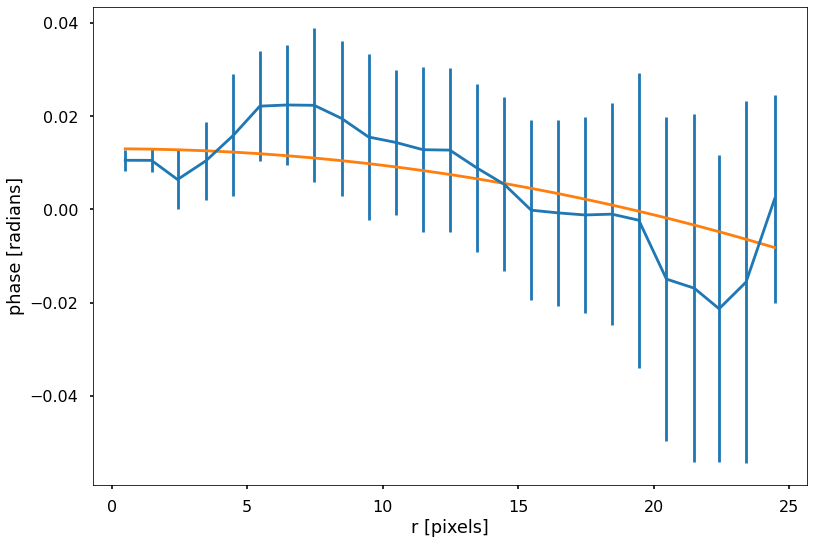

In [12]:
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    plt.errorbar(r, profile, yerr=deviations)    
    ax.plot(r, fit)
    ax.set_xlabel('r [pixels]')
    ax.set_ylabel('phase [radians]')

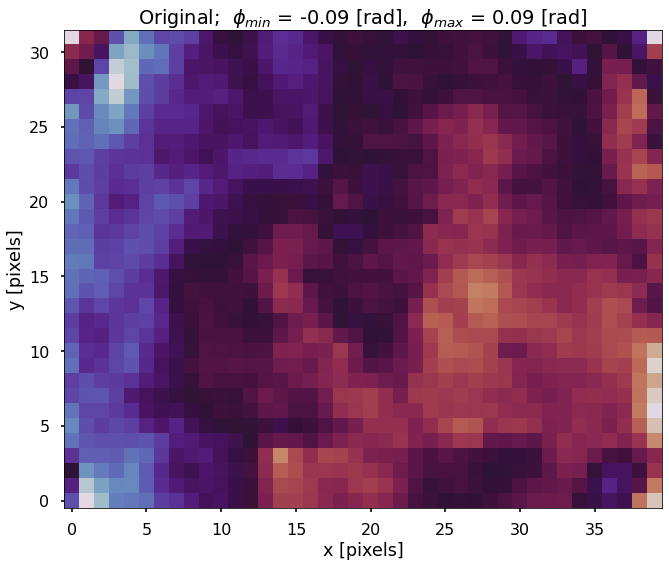

In [13]:
# plot the original data
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(wfs_data, cmap='twilight', vmin=np.min(wfs_data), vmax=np.max(wfs_data))
    ax.invert_yaxis()
    ax.set_xlabel('x [pixels]')
    ax.set_ylabel('y [pixels]')
    ax.set_title(r'Original;  $\phi_{{min}}$ ={0:6.2f} [rad]'.format(np.min(wfs_data))+',  $\phi_{{max}}$ ={0:5.2f} [rad]'.format(np.max(wfs_data)))

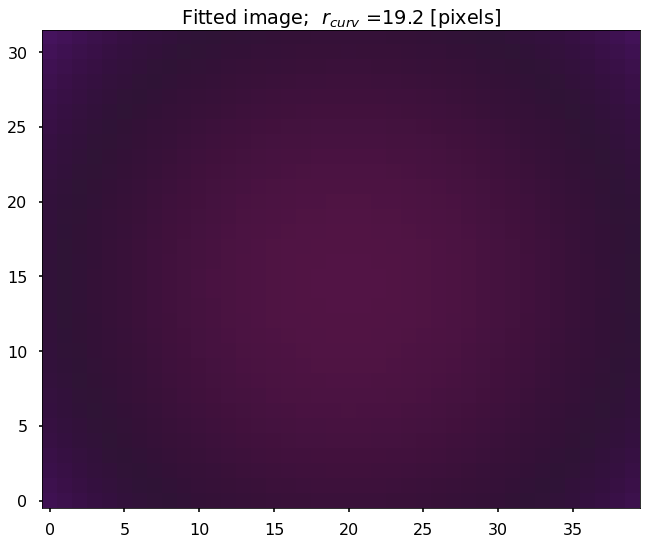

In [14]:
# plot the fitted image
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(wfs_fit, cmap='twilight', vmin=np.min(wfs_data), vmax=np.max(wfs_data))
    ax.invert_yaxis()
    ax.set_title(r'Fitted image;  $r_{{curv}}$ ={0:4.1f} [pixels]'.format(r0))

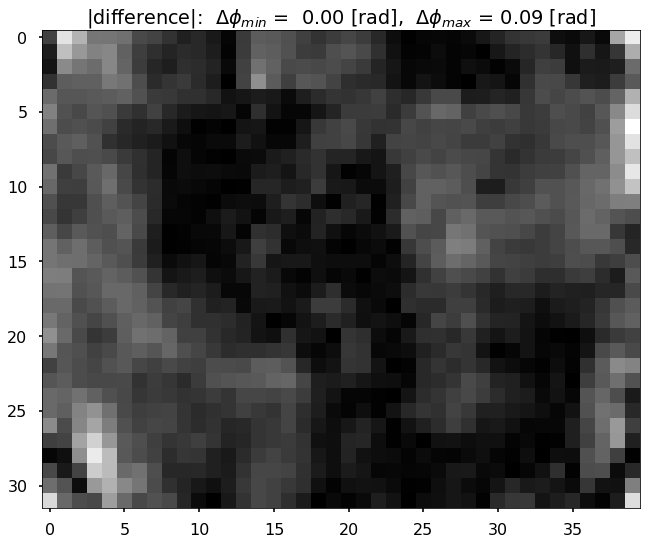

In [15]:
# plot the difference between the original and the Gaussian fit
 
wfs_diff = np.abs(wfs_data - wfs_fit)
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.invert_yaxis()
    ax.imshow(wfs_diff, cmap='gray', vmin=np.min(wfs_diff), vmax=np.max(wfs_diff))
    ax.set_title(r'|difference|:  $\Delta\phi_{{min}}$ ={0:6.2f} [rad]'.format(np.min(wfs_diff))+',  $\Delta\phi_{{max}}$ ={0:5.2f} [rad]'.format(np.max(wfs_diff)))

In [16]:
# calculate and print some absolute values for the photon counts

print(' ')
print('*************************')
# print('wfs_data = ')
# print(wfs_data)
min_data = np.min(wfs_data)
max_data = np.max(wfs_data)
print('min original = ', min_data)
print('max original = ', max_data)

print(' ')
print('*************************')
# print('wfs_fit = ')
# print(wfs_fit)
min_fit = np.min(wfs_fit)
max_fit = np.max(wfs_fit)
print('min fitted = ', min_fit)
print('max fitted = ', max_fit)

print(' ')
print('*************************')
# print('wfs_diff = ')
# print(wfs_diff)
min_diff = np.min(wfs_diff)
max_diff = np.max(wfs_diff)
print('min diff = ', min_diff)
print('max diff = ', max_diff)

 
*************************
min original =  -0.08604974843169766
max original =  0.08604974843169766
 
*************************
min fitted =  -0.010876298424021533
max fitted =  0.012996776820051625
 
*************************
min diff =  1.576822339022753e-05
max diff =  0.08836550595695083


In [17]:
# Now let's fit a Gaussian to the intensity data from the CCD diagnostic file
r_rms = 0.2*r_max
x0=(r_rms, n0_max)

r_mid = 0.4*r_max
args=(x, y, xc, yc, ccd_data.flatten(), r_mid)

result = opt.minimize(gaussian_ccd_fit, x0, args, method='Nelder-Mead', options={'maxiter': 1e4, 'xatol': 0.0000001, 'fatol': 0.0000001})
print('result = ', result)

result =   final_simplex: (array([[1.32131628e+01, 4.88969631e+04],
       [1.32131628e+01, 4.88969631e+04],
       [1.32131628e+01, 4.88969631e+04]]), array([16116.31749734, 16116.31749734, 16116.31749734]))
           fun: 16116.317497339516
       message: 'Optimization terminated successfully.'
          nfev: 174
           nit: 82
        status: 0
       success: True
             x: array([1.32131628e+01, 4.88969631e+04])


In [18]:
(r_rms, nfit_max) = result.x
w0 = r_rms * math.sqrt(2.) * pixel_size
x_rms = r_rms / math.sqrt(2.) * pixel_size
ccd_fit = gaussian_ccd(x, y, xc, yc, n0_max, r_rms).reshape(ccd_data.shape)

# compare the total photon count
nfit_tot = np.sum(ccd_fit)
rel_tot_dif = 100.*(1.-nfit_tot/n0_tot)
print('nfit_tot = {0:4.0f}'.format(nfit_tot))
print('relative difference of total counts = {0:3.1f}%'.format(rel_tot_dif))

# compare the center location with values calculated above
yc_ccd, xc_ccd = ndimage.measurements.center_of_mass(ccd_data) 
print('xc_ccd ~ {0:4.1f}'.format(xc_ccd) + ';  yc_ccd ~ {0:4.1f}'.format(yc_ccd))
print('xc_wfs ~ {0:4.1f}'.format(xc)     + ';  yc_wfs ~ {0:4.1f}'.format(yc))

nfit_tot = 25541612
relative difference of total counts = 6.2%
xc_ccd ~ 20.0;  yc_ccd ~ 14.4
xc_wfs ~ 20.0;  yc_wfs ~ 14.4


In [19]:
profile, deviations, r = azimuthalAverage(ccd_data, xc, yc)
print(' ')
print(' r = ', r)
print(' profile = ', profile)

fit = np.zeros(profile.shape[0])
fit = nfit_max*np.exp(-(r/r_rms)**2)
print(' fit = ', fit)

 
 r =  [ 0.50019092  1.46935702  2.43038667  3.47962655  4.49492831  5.46695948
  6.48582635  7.47526355  8.48250765  9.48027423 10.47608067 11.49079116
 12.47881298 13.48105788 14.48835284 15.48114428 16.48650026 17.46517074
 18.45945576 19.45256716 20.47161304 21.4988624  22.41524957 23.40978267
 24.46196177]
 profile =  [50643.         46791.         45812.71428571 44552.20833333
 42993.39285714 40805.8125     37959.31111111 35792.45238095
 33175.70689655 31152.5        29734.41791045 27921.97333333
 26098.28767123 23897.96666667 21629.81818182 18131.42857143
 14519.88888889 11176.7125      8551.44444444  6039.81944444
  4592.57142857  3087.64102564  2373.41666667  1873.91666667
  1496.5       ]
 fit =  [48826.94200085 48296.01018429 47270.31691826 45620.83196975
 43553.45422854 41203.59004701 38427.40068963 35504.14182264
 32381.4136879  29222.16538455 26078.2392314  22952.54646435
 20041.01157225 17266.26312084 14693.1757186  12390.89383903
 10307.55847908  8521.20373952  6944.60

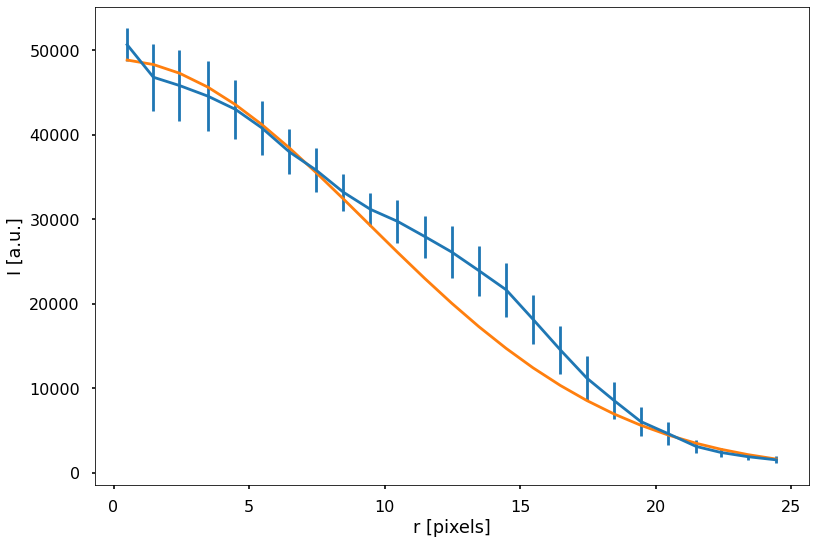

In [20]:
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    plt.errorbar(r, profile, yerr=deviations)    
    ax.plot(r, fit)
    ax.set_xlabel('r [pixels]')
    ax.set_ylabel('I [a.u.]')

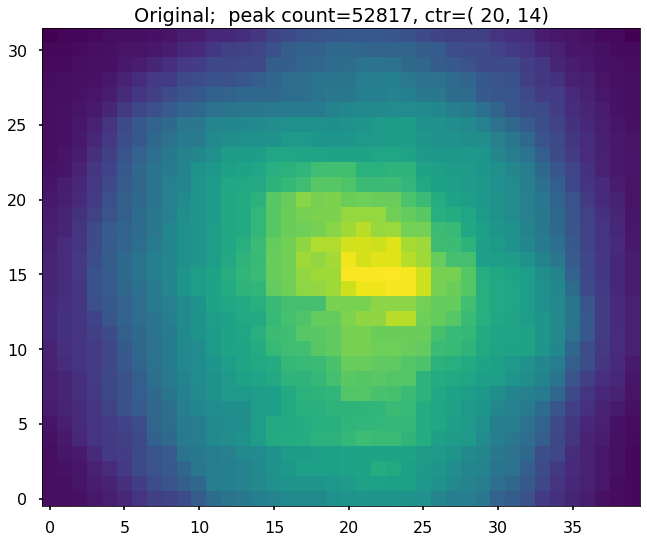

In [21]:
# plot the original image
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(ccd_data, cmap='viridis', vmin=0., vmax=n0_max)
    ax.invert_yaxis()
    ax.set_title('Original;  peak count={0:4.0f}'.format(n0_max)+', ctr=({0:3.0f},'.format(xc)+'{0:3.0f})'.format(yc))

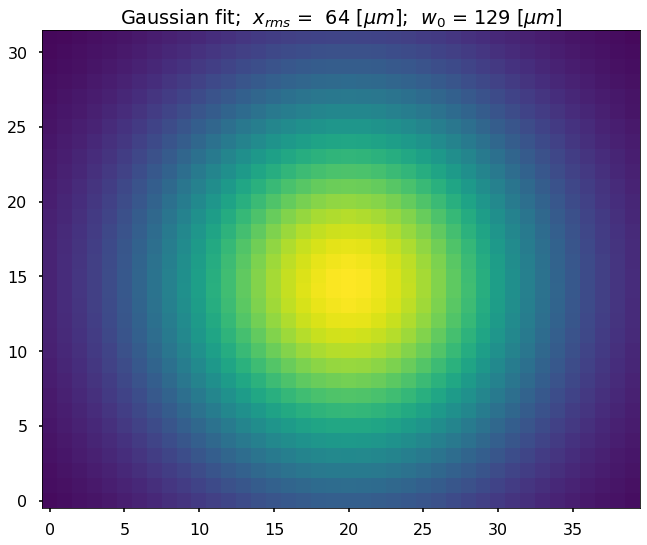

In [22]:
# plot the fitted Gaussian image
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(ccd_fit, cmap='viridis', vmin=0., vmax=n0_max)
    ax.invert_yaxis()
    ax.set_title(r'Gaussian fit;  $x_{{rms}}$ ={0:4.0f} [$\mu m$]'.format(x_rms) + ';  $w_0$ ={0:4.0f} [$\mu m$]'.format(w0))

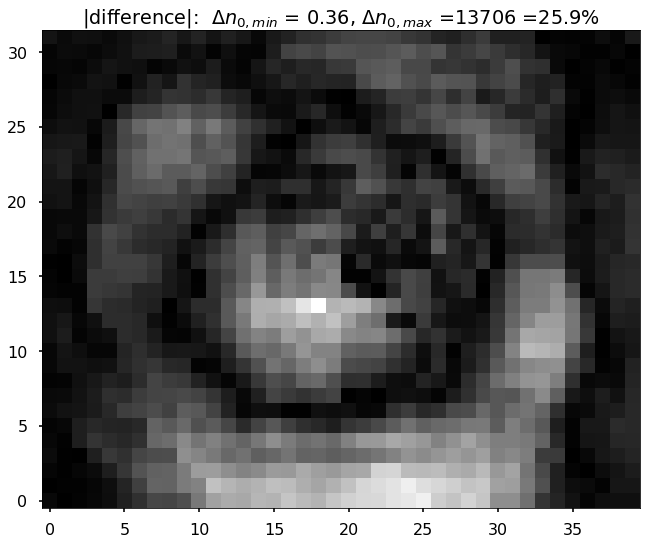

In [23]:
# plot the difference between the original and the Gaussian fit
 
ccd_diff = np.abs(ccd_data - ccd_fit)
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(ccd_diff, cmap='gray', vmin=np.min(ccd_diff), vmax=np.max(ccd_diff))
    ax.invert_yaxis()
    ax.set_title(r'|difference|:  $\Delta n_{{0, min}}$ ={0:5.2f}'.format(np.min(ccd_diff))+r', $\Delta n_{{0, max}}$ ={0:5.0f}'.format(np.max(ccd_diff))+r' ={0:4.1f}%'.format(100.*(np.max(ccd_diff)/n0_max)))

In [24]:
# calculate and print some absolute values for the photon counts

print(' ')
print('*************************')
# print('ccd_data = ')
# print(ccd_data)
min_orig = np.min(ccd_data)
max_orig = np.max(ccd_data)
print('min original = ', min_orig)
print('max original = ', max_orig)

print(' ')
print('*************************')
# print('ccd_fit = ')
# print(ccd_fit)
min_fit = np.min(ccd_fit)
max_fit = np.max(ccd_fit)
print('min fitted = ', min_fit)
print('max fitted = ', max_fit)

print(' ')
print('*************************')
# print('ccd_diff = ')
# print(ccd_diff)
min_diff = np.min(ccd_diff)
max_diff = np.max(ccd_diff)
print('min diff = ', min_diff)
print('max diff = ', max_diff)

 
*************************
min original =  0.0
max original =  52817.0
 
*************************
min fitted =  1110.9712716018525
max fitted =  52762.35283163846
 
*************************
min diff =  0.3645609563554899
max diff =  13705.737910893746
